<a href="https://colab.research.google.com/github/junranshi/capstone_moonboard/blob/main/Classification_Finalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info
In this notebook we perform grade classification on MoonBoard routes. We first use five different machine learning models to determine baseline results for classification metrics. Then we choose logistic regression and XGBoost as our main classifiers and examine the effects of two methods to handle the severe class imbalance in our dataset: using balanced class weights and incorporating generated routes for minority classes during training.

# Import packages and datasets

In [15]:
import pandas as pd
import sys
import os
import pickle
import random
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

from imblearn.metrics import classification_report_imbalanced
import seaborn as sns
from collections import Counter

In [8]:
!git clone https://github.com/junranshi/capstone_moonboard.git

fatal: destination path 'capstone_moonboard' already exists and is not an empty directory.


In [19]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [10]:
# import data

# original dataset
with open('/content/capstone_moonboard/data/cleaned.p', 'rb') as f:
    mb_2016 = pickle.load(f)

# first set of generated routes
with open('classification_routes0.p', 'rb') as f:
    gen_routes0 = pickle.load(f)

# second set of generated routes
with open('classification_routes1.p', 'rb') as f:
    gen_routes1 = pickle.load(f)

# third set of generated routes
with open('classification_routes2.p', 'rb') as f:
    gen_routes2 = pickle.load(f)

# Define functions to be used

In [11]:
def get_holds(item, hold_types):
    """
    get a list of holds from a route
    input hold_types is a list of combination of 'start', 'mid', 'end'
    """
    route = []
    for t in hold_types:
        for hold in item[t]:
            route.append(hold)
    return route

def display_matrix(matrix):
    """
    flip the matrix to present as 18*11
    """
    return np.flip(matrix.T, 0)

def get_matrices(data, hold_types):
    """
    return a dictionary and a list of matrices for the data input (eg mb_2016)
    """
    d = {}
    l = []
    for key in data:
        route = get_holds(data[key], hold_types)
        d[key] = display_matrix(convert_matrix(route))
        l.append(display_matrix(convert_matrix(route)))
    return d, l

def convert_matrix(list):
    """
    one hot encode a list of holds to 11*18 binary matrix
    """
    matrix = np.zeros((11,18))
    for hold in list:
        x = hold[0]
        y = hold[1]
        matrix[x][y] = 1
    return matrix

def metrics(actual, predicted, predicted_prob):
    """
    Print classification report and confusion matrix for the results of a classification model.
    ---
    Inputs:
    - actual: list of actual y values
    - predicted: list of predicted y values
    """
    print("\nClassification report:\n" + classification_report(actual, predicted, zero_division = 0))
    print("\nImbalanced classification report:\n" + classification_report_imbalanced(actual, predicted))
    print("\nBalanced accuracy score:",balanced_accuracy_score(actual, predicted))
    print("\nAUC:", roc_auc_score(actual, predicted_prob, multi_class='ovo'))
    print("\nAccuracy within 1 grade:", within_x_accuracy(actual, predicted, 1))
    print("\nAccuracy within 2 grades:", within_x_accuracy(actual, predicted, 2))
    
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, predicted)
    ax = plt.axes()
    sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d', cmap = 'RdPu', ax = ax )
    ax.set_title('Confusion Matrix')
    plt.show()

def within_x_accuracy(predicted, actual, x):
    """
    given a list of predictions and a list of actual grades, calculate classification accuracy of +/-x grades
    """
    if len(predicted) == len(actual):
      num = (abs(actual - predicted) <= x).sum()
      return num / len(actual)

def cross_val(model, k):
    """
    Perform kfold cross validation and print results.
    ---
    Inputs:
    - model: trained classification model
    - k: number of splits/iterations
    """
    # kfold cross validation with k splits
    cv = KFold(n_splits=k, random_state=1, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv)

    # scatterplot of cross validation scores and mean score
    x = range(k)
    plt.scatter(x, scores)
    plt.axhline(y=np.mean(scores), color = 'red')
    plt.title('k-fold cross validation results')
    plt.xlabel('CV iteration')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.1])
    print('\n')
    plt.show()
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [38]:
def vis_history(history):
  """
  visualize training history for neural networks
  """
  fig, ax = plt.subplots(figsize=(16,9), dpi=70)
  plt.title(label='Model Loss by Epoch', loc='center')

  ax.plot(history.history['loss'], label='Training Data', color='black')
  ax.plot(history.history['val_loss'], label='Test Data', color='red')
  ax.set(xlabel='Epoch', ylabel='Loss')
  plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
  plt.legend()
  plt.show()

# Principal component analysis

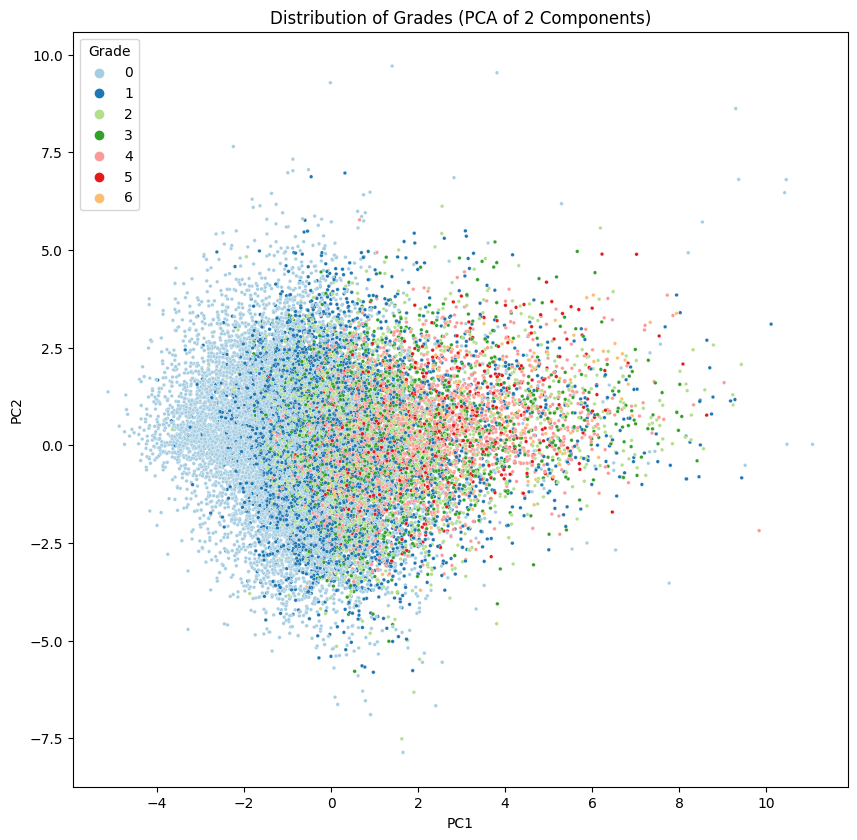

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)

plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=Xt[:,0], y=Xt[:,1], hue=y, palette="Paired", s = 7, legend="full")
ax.set(xlabel='PC1', ylabel='PC2', title = 'Distribution of Grades (PCA of 2 Components)')

plt.show()

# Baseline Models
In this section we train and study the results of five models: logistic regression, naive bayes, random forest, XGBoost, and a simple convolutional neural network.

In [39]:
# get one-hot encoded matrix representations of all routes
all_matrices = get_matrices(mb_2016, ['start', 'mid', 'end'])[1]
# get all grades
all_grades = [mb_2016[x]['grade'] for x in mb_2016]
# reshape matrices into vectors to be used as inputs
sample_vectors = [(all_matrices[i]).reshape(1, 198).tolist()[0] for i in range(len(mb_2016))]

# collect all routes and grades in a dataframe representation
df_onehot = pd.DataFrame(sample_vectors)
df_onehot['Grade'] = all_grades
df_onehot.head()

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,Grade
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## Logistic Regression

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1814
           1       0.41      0.55      0.47      1408
           2       0.24      0.10      0.14       631
           3       0.23      0.07      0.11       457
           4       0.36      0.50      0.42       477
           5       0.25      0.08      0.12       158
           6       0.56      0.07      0.12        75

    accuracy                           0.50      5020
   macro avg       0.39      0.31      0.30      5020
weighted avg       0.47      0.50      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.76      0.82      0.73      0.79      0.62      1814
          1       0.41      0.55      0.69      0.47      0.62      0.38      1408
          2       0.24      0.10      0.95      0.14      0.31     

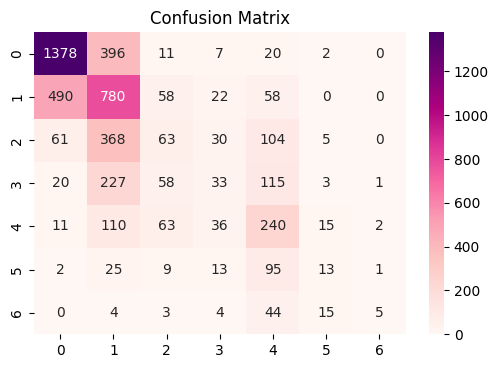

In [24]:
# logistic regression classifier

log_classifier = LogisticRegression(random_state = 0, max_iter=3000)
log_classifier.fit(X_train, y_train)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
metrics(y_test, log_predicted, log_predicted_prob)

## Naive Bayes

Model: Naive Bayes

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.77      0.64      1814
           1       0.39      0.25      0.30      1408
           2       0.20      0.13      0.16       631
           3       0.18      0.12      0.14       457
           4       0.29      0.10      0.15       477
           5       0.07      0.11      0.08       158
           6       0.10      0.53      0.17        75

    accuracy                           0.40      5020
   macro avg       0.25      0.29      0.23      5020
weighted avg       0.38      0.40      0.37      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.77      0.63      0.64      0.70      0.49      1814
          1       0.39      0.25      0.85      0.30      0.46      0.20      1408
          2       0.20      0.13      0.92      0.16      0.35      0.11   

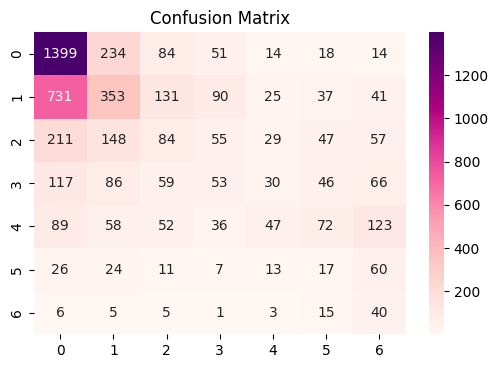

In [25]:
nb = GaussianNB()
nb_predicted = nb.fit(X_train, y_train).predict(X_test)
nb_predicted_prob = nb.predict_proba(X_test)

print("Model: Naive Bayes")
metrics(y_test, nb_predicted, nb_predicted_prob)

## Random Forest

Model: Random Forest

Classification report:
              precision    recall  f1-score   support

           0       0.37      1.00      0.54      1814
           1       0.19      0.02      0.04      1408
           2       0.00      0.00      0.00       631
           3       0.00      0.00      0.00       457
           4       0.00      0.00      0.00       477
           5       0.00      0.00      0.00       158
           6       0.00      0.00      0.00        75

    accuracy                           0.37      5020
   macro avg       0.08      0.15      0.08      5020
weighted avg       0.19      0.37      0.21      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.37      1.00      0.04      0.54      0.21      0.05      1814
          1       0.19      0.02      0.97      0.04      0.14      0.02      1408
          2       0.00      0.00      1.00      0.00      0.00      0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


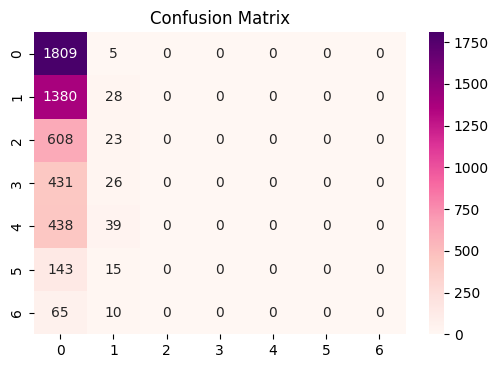

In [26]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf_predicted = rf.fit(X_train, y_train).predict(X_test)
rf_predicted_prob = rf.predict_proba(X_test)

print("Model: Random Forest")
metrics(y_test, rf_predicted, rf_predicted_prob)

## XGBoost

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      1814
           1       0.39      0.55      0.46      1408
           2       0.26      0.10      0.14       631
           3       0.18      0.08      0.11       457
           4       0.37      0.44      0.40       477
           5       0.24      0.10      0.14       158
           6       0.42      0.13      0.20        75

    accuracy                           0.49      5020
   macro avg       0.36      0.31      0.31      5020
weighted avg       0.46      0.49      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.71      0.76      0.82      0.73      0.79      0.62      1814
          1       0.39      0.55      0.67      0.46      0.61      0.36      1408
          2       0.26      0.10      0.96      0.14      0.31      0.09       

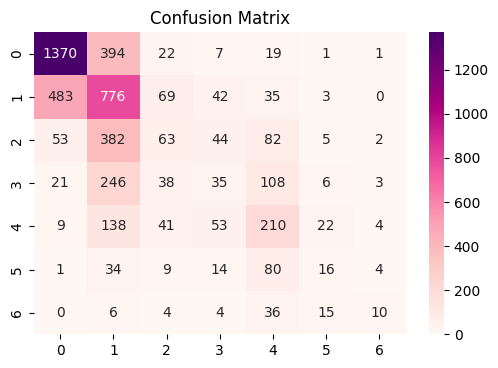

In [27]:
# original 
xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train, y_train).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)

## Convolutional neural network

In [31]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.keras import layers

import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model # for plotting model diagram

In [41]:
# reshape the representation of routes to be used as inputs to the CNN
resized_matrices = []
input_shape = (20,20,1)
for matrix in all_matrices:
  resized_matrices.append((np.pad(matrix, ((0,2),(0,9)), mode='constant', constant_values=0).reshape(input_shape)))

X = resized_matrices

input_shape = (20,20,1) 

X = np.array(X, dtype = 'float32')
y = np.array(y, dtype = 'float32')

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2,random_state = 42)

num_classes = 7

In [42]:
# default model
model = Sequential(
  [
    layers.Conv2D(filters=32, kernel_size=5, input_shape=(20, 20, 1)),
    layers.MaxPooling2D(pool_size=5),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax'),
  ]
)

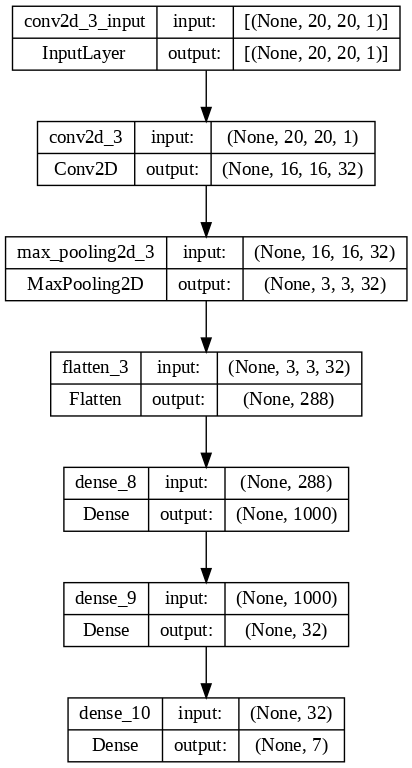

In [43]:
plot_model(model, show_shapes=True, dpi=100)

In [44]:
cnn_model = Sequential(
  [
    layers.Conv2D(filters=32, kernel_size=5, input_shape=(20, 20, 1)),
    layers.MaxPooling2D(pool_size=5),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax'),
  ]
)
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005),metrics =['accuracy'])

In [45]:
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=1,
    validation_data=(X_validate,y_validate),
)

Epoch 1/20
502/502 [==============================] - 10s 17ms/step - loss: 1.3669 - accuracy: 0.4342 - val_loss: 1.2903 - val_accuracy: 0.4659
Epoch 2/20
502/502 [==============================] - 7s 13ms/step - loss: 1.2604 - accuracy: 0.4736 - val_loss: 1.2815 - val_accuracy: 0.4848
Epoch 3/20
502/502 [==============================] - 8s 15ms/step - loss: 1.2301 - accuracy: 0.4900 - val_loss: 1.2331 - val_accuracy: 0.4918
Epoch 4/20
502/502 [==============================] - 13s 26ms/step - loss: 1.2086 - accuracy: 0.4914 - val_loss: 1.2903 - val_accuracy: 0.4739
Epoch 5/20
502/502 [==============================] - 13s 25ms/step - loss: 1.1932 - accuracy: 0.4994 - val_loss: 1.2181 - val_accuracy: 0.4933
Epoch 6/20
502/502 [==============================] - 12s 24ms/step - loss: 1.1797 - accuracy: 0.4989 - val_loss: 1.2177 - val_accuracy: 0.4988
Epoch 7/20
502/502 [==============================] - 8s 16ms/step - loss: 1.1672 - accuracy: 0.5014 - val_loss: 1.2058 - val_accuracy: 0.

157/157 [==============================] - 1s 5ms/step

Classification report:
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71      1797
         1.0       0.42      0.49      0.45      1417
         2.0       0.22      0.14      0.17       627
         3.0       0.23      0.12      0.16       462
         4.0       0.31      0.52      0.39       496
         5.0       0.18      0.06      0.09       137
         6.0       0.30      0.20      0.24        84

    accuracy                           0.48      5020
   macro avg       0.34      0.32      0.32      5020
weighted avg       0.46      0.48      0.46      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.72      0.71      0.84      0.71      0.77      0.59      1797
        1.0       0.42      0.49      0.73      0.45      0.60      0.35      1417
        2.0       0.22      0.14      0

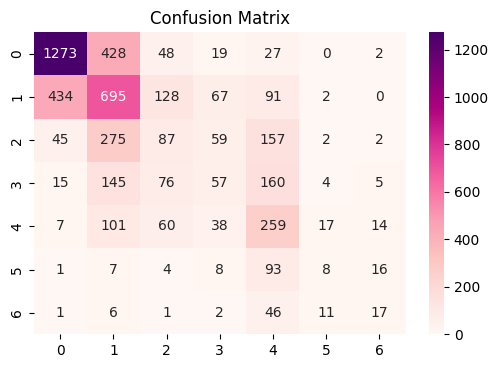

In [46]:
# results
Y_pred_cnn = np.argmax(cnn_model.predict(X_test),axis=1)
Y_pred_prob_cnn = cnn_model.predict(X_test)
metrics(y_test, Y_pred_cnn, Y_pred_prob_cnn)

# Handling class imbalance
In this section I perform a few independent experiments to examine the effects of using class weights and adding generated routes to minority classes as methods to handle class imbalance.

## Logistic Regression

In [17]:
# training and testing data
# not that the testing data is ALWAYS only from the original dataset, no generated routes
X = df_onehot.iloc[:, :-1]
y = df_onehot.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

### Original dataset

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1814
           1       0.41      0.55      0.47      1408
           2       0.24      0.10      0.14       631
           3       0.23      0.07      0.11       457
           4       0.36      0.50      0.42       477
           5       0.25      0.08      0.12       158
           6       0.56      0.07      0.12        75

    accuracy                           0.50      5020
   macro avg       0.39      0.31      0.30      5020
weighted avg       0.47      0.50      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.76      0.82      0.73      0.79      0.62      1814
          1       0.41      0.55      0.69      0.47      0.62      0.38      1408
          2       0.24      0.10      0.95      0.14      0.31     

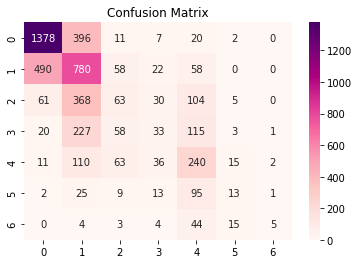

In [18]:
# initialize classifier
log_classifier = LogisticRegression(random_state = 0, max_iter=3000)
# train
log_classifier.fit(X_train, y_train)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
# get metrics
metrics(y_test, log_predicted, log_predicted_prob)
# cross_val(log_classifier, 10)

### Original dataset + class weights

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1814
           1       0.45      0.40      0.42      1408
           2       0.25      0.26      0.25       631
           3       0.21      0.23      0.22       457
           4       0.30      0.22      0.25       477
           5       0.15      0.30      0.20       158
           6       0.12      0.45      0.19        75

    accuracy                           0.45      5020
   macro avg       0.32      0.36      0.32      5020
weighted avg       0.48      0.45      0.46      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.68      0.87      0.71      0.77      0.58      1814
          1       0.45      0.40      0.81      0.42      0.57      0.31      1408
          2       0.25      0.26      0.89      0.25      0.48     

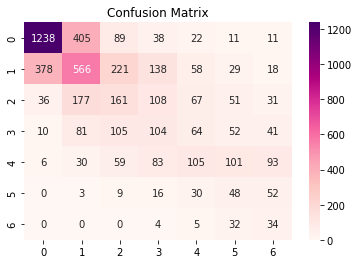

In [29]:
# add "balanced" class weights
log_classifier = LogisticRegression(random_state = 0, max_iter=3000, class_weight='balanced')
log_classifier.fit(X_train, y_train)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
metrics(y_test, log_predicted, log_predicted_prob)
# cross_val(log_classifier, 10)

### 1 set of generated routes

In [30]:
# convert generated routes into format required for training
generated_matrices0 = get_matrices(gen_routes0, ['start', 'mid', 'end'])[1]
generated_grades0 = [gen_routes0[x]['grade'] for x in gen_routes0]
generated_vectors0 = [(generated_matrices0[i]).reshape(1, 198).tolist()[0] for i in range(len(gen_routes0))]

generated_onehot0 = pd.DataFrame(generated_vectors0)
generated_onehot0['Grade'] = generated_grades0

X_generated0 = generated_onehot0.iloc[:, :-1]
y_generated0 = generated_onehot0.iloc[:, -1]

# use generated routes as training data only
X_train0 = pd.concat([X_train, X_generated0])
y_train0 = pd.concat([y_train, y_generated0])

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1814
           1       0.41      0.55      0.47      1408
           2       0.24      0.10      0.14       631
           3       0.21      0.05      0.09       457
           4       0.36      0.46      0.41       477
           5       0.19      0.13      0.16       158
           6       0.25      0.29      0.27        75

    accuracy                           0.50      5020
   macro avg       0.34      0.34      0.32      5020
weighted avg       0.46      0.50      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.76      0.82      0.73      0.79      0.62      1814
          1       0.41      0.55      0.69      0.47      0.62      0.38      1408
          2       0.24      0.10      0.96      0.14      0.30     

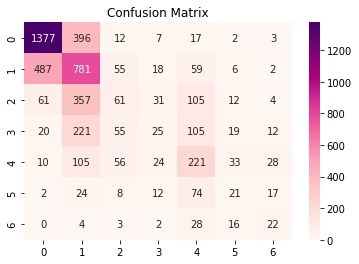

In [32]:
log_classifier = LogisticRegression(random_state = 0, max_iter=3000)
log_classifier.fit(X_train0, y_train0)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
metrics(y_test, log_predicted, log_predicted_prob)
# cross_val(log_classifier, 10)

### 1 set of generated routes + class weights

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1814
           1       0.45      0.41      0.43      1408
           2       0.24      0.25      0.24       631
           3       0.20      0.23      0.22       457
           4       0.31      0.29      0.30       477
           5       0.17      0.34      0.23       158
           6       0.19      0.40      0.26        75

    accuracy                           0.46      5020
   macro avg       0.33      0.37      0.34      5020
weighted avg       0.48      0.46      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.68      0.87      0.71      0.77      0.58      1814
          1       0.45      0.41      0.81      0.43      0.57      0.32      1408
          2       0.24      0.25      0.89      0.24      0.47     

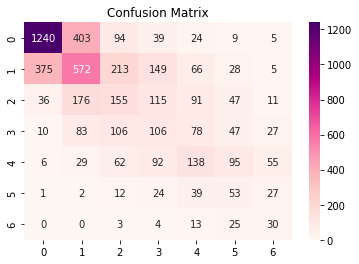

In [33]:
log_classifier = LogisticRegression(random_state = 0, max_iter=3000, class_weight='balanced')
log_classifier.fit(X_train0, y_train0)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
metrics(y_test, log_predicted, log_predicted_prob)
# cross_val(log_classifier, 10)

### 2 sets of generated routes

In [35]:
# second set of generated routes
generated_matrices1 = get_matrices(gen_routes1, ['start', 'mid', 'end'])[1]
generated_grades1 = [gen_routes1[x]['grade'] for x in gen_routes1]
generated_vectors1 = [(generated_matrices1[i]).reshape(1, 198).tolist()[0] for i in range(len(gen_routes1))]

generated_onehot1 = pd.DataFrame(generated_vectors1)
generated_onehot1['Grade'] = generated_grades1

X_generated1 = generated_onehot1.iloc[:, :-1]
y_generated1 = generated_onehot1.iloc[:, -1]

X_train1 = pd.concat([X_train0, X_generated1])
y_train1 = pd.concat([y_train0, y_generated1])

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1814
           1       0.41      0.55      0.47      1408
           2       0.25      0.09      0.14       631
           3       0.24      0.06      0.09       457
           4       0.35      0.45      0.39       477
           5       0.22      0.20      0.21       158
           6       0.27      0.37      0.31        75

    accuracy                           0.50      5020
   macro avg       0.35      0.35      0.34      5020
weighted avg       0.47      0.50      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.76      0.82      0.73      0.79      0.62      1814
          1       0.41      0.55      0.70      0.47      0.62      0.38      1408
          2       0.25      0.09      0.96      0.14      0.30     

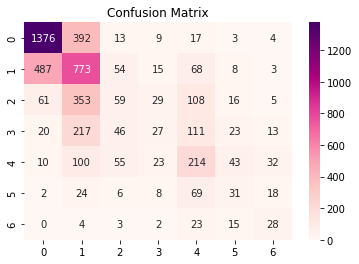

In [36]:
log_classifier = LogisticRegression(random_state = 0, max_iter=3000)
log_classifier.fit(X_train1, y_train1)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
metrics(y_test, log_predicted, log_predicted_prob)
# cross_val(log_classifier, 10)

### 2 sets of generated routes + class weights

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1814
           1       0.45      0.40      0.43      1408
           2       0.23      0.24      0.24       631
           3       0.21      0.25      0.23       457
           4       0.31      0.32      0.32       477
           5       0.19      0.32      0.23       158
           6       0.24      0.40      0.30        75

    accuracy                           0.46      5020
   macro avg       0.34      0.37      0.35      5020
weighted avg       0.48      0.46      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.69      0.87      0.71      0.77      0.58      1814
          1       0.45      0.40      0.81      0.43      0.57      0.31      1408
          2       0.23      0.24      0.89      0.24      0.46     

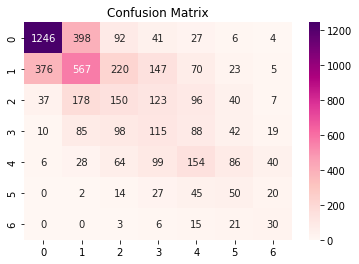

In [37]:
log_classifier = LogisticRegression(random_state = 0, max_iter=3000, class_weight='balanced')
log_classifier.fit(X_train1, y_train1)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
metrics(y_test, log_predicted, log_predicted_prob)
# cross_val(log_classifier, 10)

### 3 sets of generated routes

In [39]:
# third set of generated routes
generated_matrices2 = get_matrices(gen_routes2, ['start', 'mid', 'end'])[1]
generated_grades2 = [gen_routes2[x]['grade'] for x in gen_routes2]
generated_vectors2 = [(generated_matrices2[i]).reshape(1, 198).tolist()[0] for i in range(len(gen_routes2))]

generated_onehot2 = pd.DataFrame(generated_vectors2)
generated_onehot2['Grade'] = generated_grades2

X_generated2 = generated_onehot2.iloc[:, :-1]
y_generated2 = generated_onehot2.iloc[:, -1]

X_train2 = pd.concat([X_train1, X_generated2])
y_train2 = pd.concat([y_train1, y_generated2])

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1814
           1       0.41      0.54      0.47      1408
           2       0.24      0.09      0.13       631
           3       0.24      0.05      0.09       457
           4       0.34      0.44      0.38       477
           5       0.22      0.23      0.22       158
           6       0.25      0.37      0.30        75

    accuracy                           0.50      5020
   macro avg       0.34      0.36      0.33      5020
weighted avg       0.47      0.50      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.76      0.82      0.73      0.79      0.62      1814
          1       0.41      0.54      0.70      0.47      0.62      0.37      1408
          2       0.24      0.09      0.96      0.13      0.29     

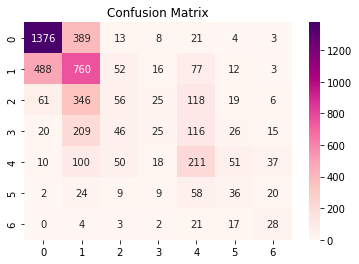

In [41]:
log_classifier = LogisticRegression(random_state = 0, max_iter=3000)
log_classifier.fit(X_train2, y_train2)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
metrics(y_test, log_predicted, log_predicted_prob)
# cross_val(log_classifier, 10)

### 3 sets of generated routes + class weights

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1814
           1       0.45      0.40      0.43      1408
           2       0.23      0.24      0.24       631
           3       0.20      0.25      0.22       457
           4       0.31      0.34      0.32       477
           5       0.20      0.30      0.24       158
           6       0.25      0.35      0.29        75

    accuracy                           0.46      5020
   macro avg       0.34      0.37      0.35      5020
weighted avg       0.48      0.46      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.69      0.87      0.71      0.77      0.58      1814
          1       0.45      0.40      0.81      0.43      0.57      0.31      1408
          2       0.23      0.24      0.89      0.24      0.46     

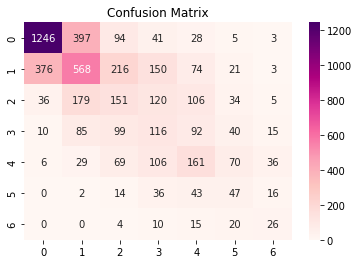

In [43]:
log_classifier = LogisticRegression(random_state = 0, max_iter=3000, class_weight='balanced')
log_classifier.fit(X_train2, y_train2)
log_predicted = log_classifier.predict(X_test)
log_predicted_prob = log_classifier.predict_proba(X_test)

print("Model: Logistic Regression")
metrics(y_test, log_predicted, log_predicted_prob)
# cross_val(log_classifier, 10)

## XGBoost

### Original dataset

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1814
           1       0.40      0.56      0.47      1408
           2       0.23      0.10      0.14       631
           3       0.21      0.10      0.13       457
           4       0.37      0.44      0.40       477
           5       0.21      0.09      0.13       158
           6       0.44      0.15      0.22        75

    accuracy                           0.50      5020
   macro avg       0.37      0.31      0.32      5020
weighted avg       0.47      0.50      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.72      0.75      0.83      0.73      0.79      0.62      1814
          1       0.40      0.56      0.67      0.47      0.62      0.37      1408
          2       0.23      0.10      0.95      0.14      0.31      0.09       

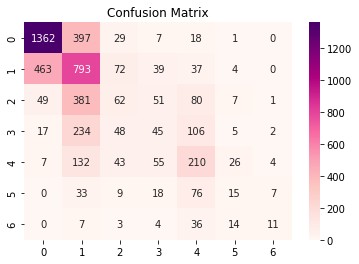

In [45]:
xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train, y_train).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)
#cross_val(xgboost, 10)

### Original dataset + class weights

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73      1814
           1       0.47      0.46      0.47      1408
           2       0.24      0.20      0.22       631
           3       0.24      0.23      0.23       457
           4       0.29      0.29      0.29       477
           5       0.16      0.30      0.20       158
           6       0.16      0.39      0.23        75

    accuracy                           0.48      5020
   macro avg       0.33      0.37      0.34      5020
weighted avg       0.49      0.48      0.48      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      0.71      0.87      0.73      0.79      0.61      1814
          1       0.47      0.46      0.80      0.47      0.61      0.36      1408
          2       0.24      0.20      0.91      0.22      0.43      0.17       

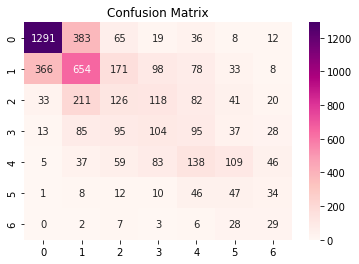

In [46]:
from sklearn.utils import class_weight

# add class weights
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y = y_train
)

xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train, y_train, sample_weight=classes_weights).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)
#cross_val(xgboost, 10)

### 1 set of generated routes

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.73      1814
           1       0.41      0.55      0.47      1408
           2       0.26      0.11      0.15       631
           3       0.24      0.09      0.13       457
           4       0.37      0.42      0.39       477
           5       0.22      0.16      0.18       158
           6       0.30      0.27      0.28        75

    accuracy                           0.50      5020
   macro avg       0.36      0.34      0.33      5020
weighted avg       0.47      0.50      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.71      0.77      0.82      0.73      0.79      0.62      1814
          1       0.41      0.55      0.69      0.47      0.61      0.37      1408
          2       0.26      0.11      0.96      0.15      0.32      0.09       

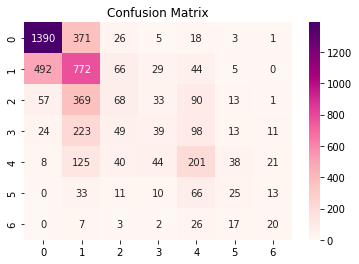

In [47]:
xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train0, y_train0).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)
#cross_val(xgboost, 10)

### 1 set of generated routes + class weights

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1814
           1       0.46      0.45      0.45      1408
           2       0.23      0.21      0.22       631
           3       0.22      0.23      0.23       457
           4       0.31      0.33      0.32       477
           5       0.16      0.25      0.20       158
           6       0.24      0.36      0.29        75

    accuracy                           0.48      5020
   macro avg       0.34      0.36      0.35      5020
weighted avg       0.49      0.48      0.48      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.71      0.87      0.73      0.78      0.61      1814
          1       0.46      0.45      0.79      0.45      0.60      0.34      1408
          2       0.23      0.21      0.90      0.22      0.44      0.18       

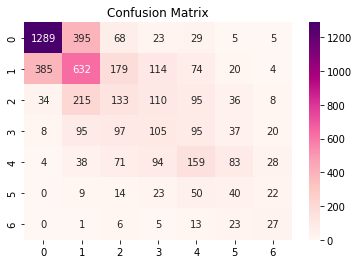

In [50]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y = y_train0
)

xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train0, y_train0, sample_weight=classes_weights).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)
#cross_val(xgboost, 10)

### 2 sets of generated routes

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.75      0.73      1814
           1       0.39      0.54      0.46      1408
           2       0.23      0.09      0.13       631
           3       0.20      0.07      0.10       457
           4       0.36      0.41      0.38       477
           5       0.20      0.16      0.18       158
           6       0.29      0.32      0.31        75

    accuracy                           0.49      5020
   macro avg       0.34      0.33      0.33      5020
weighted avg       0.46      0.49      0.46      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.75      0.82      0.73      0.79      0.62      1814
          1       0.39      0.54      0.68      0.46      0.60      0.36      1408
          2       0.23      0.09      0.96      0.13      0.29      0.08       

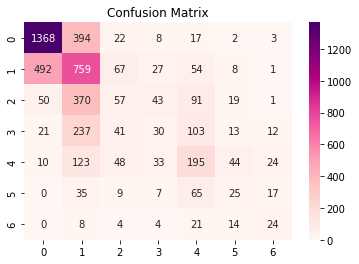

In [51]:
xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train1, y_train1).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)
#cross_val(xgboost, 10)

### 2 sets of generated routes + class weights

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1814
           1       0.45      0.45      0.45      1408
           2       0.23      0.22      0.22       631
           3       0.23      0.25      0.24       457
           4       0.31      0.35      0.33       477
           5       0.18      0.24      0.20       158
           6       0.29      0.41      0.34        75

    accuracy                           0.47      5020
   macro avg       0.35      0.37      0.36      5020
weighted avg       0.49      0.47      0.48      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.69      0.87      0.72      0.78      0.59      1814
          1       0.45      0.45      0.79      0.45      0.60      0.34      1408
          2       0.23      0.22      0.90      0.22      0.44      0.18       

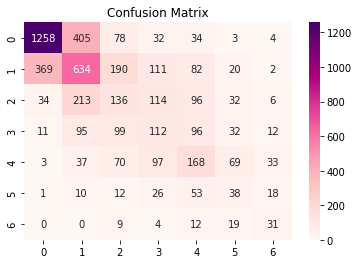

In [52]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y = y_train1
)

xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train1, y_train1, sample_weight=classes_weights).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)
#cross_val(xgboost, 10)

### 3 sets of generated routes 

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1814
           1       0.40      0.53      0.46      1408
           2       0.26      0.10      0.14       631
           3       0.23      0.08      0.12       457
           4       0.36      0.43      0.39       477
           5       0.23      0.22      0.22       158
           6       0.31      0.33      0.32        75

    accuracy                           0.50      5020
   macro avg       0.36      0.35      0.34      5020
weighted avg       0.47      0.50      0.47      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.76      0.82      0.73      0.79      0.62      1814
          1       0.40      0.53      0.69      0.46      0.60      0.36      1408
          2       0.26      0.10      0.96      0.14      0.31      0.09       

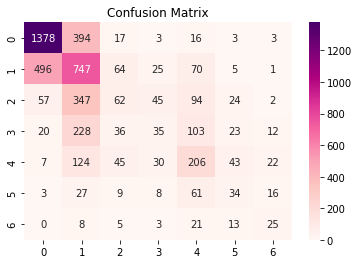

In [53]:
xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train2, y_train2).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)
#cross_val(xgboost, 10)

### 3 sets of generated routes + class weights

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1814
           1       0.46      0.45      0.46      1408
           2       0.21      0.19      0.20       631
           3       0.21      0.24      0.23       457
           4       0.31      0.36      0.33       477
           5       0.20      0.24      0.22       158
           6       0.29      0.36      0.32        75

    accuracy                           0.48      5020
   macro avg       0.35      0.36      0.35      5020
weighted avg       0.49      0.48      0.48      5020


Imbalanced classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.71      0.87      0.73      0.78      0.60      1814
          1       0.46      0.45      0.79      0.46      0.60      0.35      1408
          2       0.21      0.19      0.90      0.20      0.41      0.16       

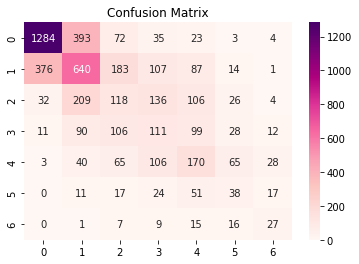

In [54]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y = y_train2
)

xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train2, y_train2, sample_weight=classes_weights).predict(X_test)
xgboost_predicted_prob = xgboost.predict_proba(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted, xgboost_predicted_prob)
#cross_val(xgboost, 10)

# Classify website routes
In this section, we load the routes generated by the VAE models to be displayed on the website and use logistic regression and XGBoost models to classify their grades. These grade predictions will be displayed to the users on the demo website as well. The models we choose are the ones trained using original dataset + three sets of generate routes and using class weights.

In [76]:
with open('website_routes.p', 'rb') as f:
    website_routes = pickle.load(f)

In [77]:
# update the keys in the website_routes dictionary to be consistent with file names in the image folder for website
curr = 0
for n in range(645):
  if n < 10:
    n = '00' + str(n)
  elif n < 100:
    n = '0' + str(n)
  else:
    n = str(n)
  if n in website_routes:
    website_routes[curr] = website_routes.pop(str(n))
    curr += 1

In [78]:
# convert the routes into input format for the classifiers
website_matrices = get_matrices(website_routes, ['start', 'mid', 'end'])[1]
website_grades = [website_routes[x]['grade'] for x in website_routes]
website_vectors = [(website_matrices[i]).reshape(1, 198).tolist()[0] for i in range(len(website_routes))]

website_onehot = pd.DataFrame(website_vectors)
website_onehot['Grade'] = website_grades

X_website = website_onehot.iloc[:, :-1]
y_website = website_onehot.iloc[:, -1]

In [79]:
logistic_predicted = log_classifier.predict(X_website)

In [80]:
xgboost_predicted = xgboost.predict(X_website)

In [81]:
logistic_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 4, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 5, 3, 1, 1, 1, 4, 4,
       4, 4, 1, 3, 4, 2, 3, 1, 4, 1, 5, 3, 4, 4, 4, 5, 6, 4, 5, 4, 4, 4,
       1, 5, 4, 4, 4, 4, 4, 5, 5, 6, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6])

In [82]:
xgboost_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 1, 1,
       2, 0, 4, 4, 4, 4, 1, 1, 1, 0, 1, 4, 0, 4, 4, 5, 4, 1, 1, 2, 4, 2,
       3, 4, 1, 3, 3, 4, 4, 1, 5, 1, 6, 6, 4, 4, 5, 5, 6, 4, 5, 4, 4, 4,
       4, 4, 3, 4, 4, 4, 4, 5, 5, 6, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6])

In [83]:
for key, item in website_routes.items():
  item['logistic'] = logistic_predicted[key]
  item['xgboost'] = xgboost_predicted[key]

# save classification results as pickle and text to be used for display on the website
!touch website_routes_classified.p
pickle.dump(website_routes, open('website_routes_classified.p', 'wb'))
!touch website_routes_classified.txt